In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor

import pandas as pd
import numpy as np
import sklearn
import shap
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import time

In [2]:
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('extended_stoma_dataset.csv')

In [4]:
data = data.dropna() 

In [5]:
data = data.drop(columns=['previous_place_of_living','place_of_birth'])

data['end_year'] = data.dates.apply(lambda a: int(a.split('-')[1]))
data['birth_year'] = data['date_of_birth'].apply(lambda a: int('20'+a.split('.')[-1] ))
data['right_age'] = data[['end_year', 'birth_year']].apply(lambda a: a[0]-a[1], axis=1)
data['kpu'] = data[['num_caries', 'num_filling_caries',
                    'num_filling_no_caries',
                    'num_removed_caused_by_caries', 'num_removed_other_reasons']].sum(axis=1)

train = data.drop(data[data['dates'] == '2017-2018'].index, axis=0)
test = data[data['dates'] == '2017-2018']

NUM_FEATURES = [
       'prosthesis crown veneer', 'sealed fissure', 'uncut tooth', 'fluorosis',
               'sum_hygiene_index', 'right_age', ]
LAST_FEATURES = [ 'not_registered', 'num_caries',
       'num_filling_caries', 'num_filling_no_caries', 'num_healthy',
       'num_removed_caused_by_caries', 'num_removed_other_reasons',] #признаки, участвующие в расчете целевой метрики, берем их только за последний год
TARGET = ['kpu']
CAT_FEATURES = ['nationality', 'bite_type', ]

x_mean = train[NUM_FEATURES+['id']].groupby('id').mean()
x_cat = train[CAT_FEATURES+['id']].groupby('id').agg(lambda x:x.value_counts().index[0])
last_names = [c+' last' for c in NUM_FEATURES]
x_last = pd.DataFrame(columns=[c+' last' for c in NUM_FEATURES])
x_last[last_names] = train[NUM_FEATURES+['id']].groupby('id').last()

last_cor_target_names = [c+' previous year' for c in LAST_FEATURES]
x_prev_year = pd.DataFrame(columns=last_cor_target_names)
x_prev_year = train[LAST_FEATURES+['id']].groupby('id').agg(lambda x: x.iloc[:len(x)-1].iloc[-1])

x_past_target = train[TARGET+['id']].groupby('id').agg(lambda x: x.iloc[:len(x)-1].iloc[-1])
x_past_target.columns = ['kpu_last']
x_past_target['kpu'] = train[TARGET+['id']].groupby('id').agg(lambda x: x.iloc[-1])

x_mean_test = data[NUM_FEATURES+['id']].groupby('id').mean()
x_cat_test = data[CAT_FEATURES+['id']].groupby('id').agg(lambda x:x.value_counts().index[0])
last_names = [c+' last' for c in NUM_FEATURES]
x_last_test = pd.DataFrame(columns=[c+' last' for c in NUM_FEATURES])
x_last_test[last_names] = data[NUM_FEATURES+['id']].groupby('id').last()

last_cor_target_names = [c+' previous year' for c in LAST_FEATURES]
x_prev_year_test = pd.DataFrame(columns=last_cor_target_names)
x_prev_year_test = data[LAST_FEATURES+['id']].groupby('id').agg(lambda x: x.iloc[:len(x)-1].iloc[-1])

x_past_target_test = data[TARGET+['id']].groupby('id').agg(lambda x: x.iloc[:len(x)-1].iloc[-1])
x_past_target_test.columns = ['kpu_last']
x_past_target_test['kpu'] = data[TARGET+['id']].groupby('id').agg(lambda x: x.iloc[-1])

x_train = pd.concat([x_mean, x_cat, x_last,x_prev_year_test, x_past_target['kpu_last']], axis=1)
x_train_with_kpu = pd.concat([x_mean, x_cat, x_last,x_prev_year_test, x_past_target], axis=1)
y_train = x_past_target['kpu']


x_test = pd.concat([x_mean_test, x_cat_test, x_last_test, x_prev_year_test, x_past_target_test['kpu_last']], axis=1)
x_test_with_kpu = pd.concat([x_mean_test, x_cat_test, x_last_test, x_prev_year_test, x_past_target_test], axis=1)
y_test = test[['id', 'kpu']].groupby('id').last()

label = 'kpu'

In [6]:
x_train,x_valid,y_train,y_valid = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [7]:
print("Possible classes: \n", x_test_with_kpu[label].value_counts())

Possible classes: 
 4     30
0     23
6     19
5     19
2     17
3     16
7     15
8     15
1     13
9      9
10     3
12     2
16     1
15     1
13     1
11     1
Name: kpu, dtype: int64


In [8]:
feature_names = x_train.columns
train_data = x_train.copy()
train_data[label] = y_train
val_data = x_valid.copy()

display(train_data.head())

,prosthesis crown veneer,sealed fissure,uncut tooth,fluorosis,sum_hygiene_index,right_age,nationality,bite_type,prosthesis crown veneer last,sealed fissure last,...,right_age last,not_registered,num_caries,num_filling_caries,num_filling_no_caries,num_healthy,num_removed_caused_by_caries,num_removed_other_reasons,kpu_last,kpu
id,,,,,,,,,,,,,,,,,,,,,
3407.xlsx,0.0,0.000000,0.0,0.0,0.0,8.5,русский,Ортогнатический,0,0,...,11,4,2,0,1,21,0,0,0,3
1109.xlsx,0.0,0.000000,0.0,0.0,2.0,14.5,русский,ортогнатический,0,0,...,17,1,4,1,3,19,0,0,6,8
3310.xlsx,0.0,0.000000,0.0,0.0,0.0,8.5,русский,Ортогнатический,0,0,...,11,4,0,1,4,19,0,0,0,5
7402.xlsx,0.0,0.000000,0.0,0.0,0.0,11.5,русский,ортогнатический,0,0,...,14,0,0,0,0,28,0,0,0,0
1405.xlsx,0.0,5.666667,0.0,0.0,0.0,13.5,русский,ортогнатический,0,8,...,16,0,0,0,1,19,0,0,1,1


In [9]:
predictor = TabularPredictor(label=label, problem_type='regression').fit(train_data, time_limit=20)

No path specified. Models will be saved in: "AutogluonModels/ag-20220614_131428/"
Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to "AutogluonModels/ag-20220614_131428/"
AutoGluon Version:  0.4.2
Python Version:     3.8.10
Operating System:   Linux
Train Data Rows:    148
Train Data Columns: 22
Label Column: kpu
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3511.58 MB
	Train Data (Original)  Memory Usage: 0.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFea

[1000]	valid_set's rmse: 0.806316


	-0.8062	 = Validation score   (root_mean_squared_error)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 18.65s of the 18.64s of remaining time.


[1000]	valid_set's rmse: 0.822126


	-1.0597	 = Validation score   (root_mean_squared_error)
	0.59s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 17.96s of the 17.96s of remaining time.
	-0.7805	 = Validation score   (root_mean_squared_error)
	10.61s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 7.33s of the 7.33s of remaining time.
	-0.8566	 = Validation score   (root_mean_squared_error)
	0.58s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 6.65s of the 6.65s of remaining time.
	-0.3511	 = Validation score   (root_mean_squared_error)
	1.32s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 5.31s of the 5.31s of remaining time.
	-1.1077	 = Validation score   (root_mean_squared_error)
	0.21s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ... Training model

[1000]	valid_set's rmse: 0.854155


	-0.8535	 = Validation score   (root_mean_squared_error)
	0.63s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 19.69s of the 2.61s of remaining time.
	-0.3502	 = Validation score   (root_mean_squared_error)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 17.73s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220614_131428/")


In [10]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1, -1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [11]:
x_train = MultiColumnLabelEncoder(columns = ['nationality','bite_type']).fit_transform(x_train)
x_valid = MultiColumnLabelEncoder(columns = ['nationality','bite_type']).fit_transform(x_valid)
x_test = MultiColumnLabelEncoder(columns = ['nationality','bite_type']).fit_transform(x_test)

feature_names = x_train.columns

In [12]:
x_train

,prosthesis crown veneer,sealed fissure,uncut tooth,fluorosis,sum_hygiene_index,right_age,nationality,bite_type,prosthesis crown veneer last,sealed fissure last,...,sum_hygiene_index last,right_age last,not_registered,num_caries,num_filling_caries,num_filling_no_caries,num_healthy,num_removed_caused_by_caries,num_removed_other_reasons,kpu_last
id,,,,,,,,,,,,,,,,,,,,,
3407.xlsx,0.0,0.000000,0.0,0.0,0.0,8.5,1,2,0,0,...,0.0,11,4,2,0,1,21,0,0,0
1109.xlsx,0.0,0.000000,0.0,0.0,2.0,14.5,1,8,0,0,...,2.0,17,1,4,1,3,19,0,0,6
3310.xlsx,0.0,0.000000,0.0,0.0,0.0,8.5,1,2,0,0,...,0.0,11,4,0,1,4,19,0,0,0
7402.xlsx,0.0,0.000000,0.0,0.0,0.0,11.5,1,8,0,0,...,0.0,14,0,0,0,0,28,0,0,0
1405.xlsx,0.0,5.666667,0.0,0.0,0.0,13.5,1,8,0,8,...,0.0,16,0,0,0,1,19,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317.xlsx,0.0,0.000000,0.0,0.0,0.0,8.5,1,2,0,0,...,0.0,11,4,3,0,5,16,0,0,0
3117.xlsx,0.0,0.000000,0.0,0.0,2.0,8.5,1,8,0,0,...,2.0,11,4,1,0,0,21,0,0,0
3411.xlsx,0.0,0.000000,0.0,0.0,0.0,8.5,1,2,0,0,...,0.0,11,4,2,0,0,21,1,0,0


In [13]:
y_train.shape

(148,)

In [14]:
y_train = y_train.to_numpy()

In [15]:
y_train = list(y_train)

In [16]:
x_valid

,prosthesis crown veneer,sealed fissure,uncut tooth,fluorosis,sum_hygiene_index,right_age,nationality,bite_type,prosthesis crown veneer last,sealed fissure last,...,sum_hygiene_index last,right_age last,not_registered,num_caries,num_filling_caries,num_filling_no_caries,num_healthy,num_removed_caused_by_caries,num_removed_other_reasons,kpu_last
id,,,,,,,,,,,,,,,,,,,,,
1305.xlsx,0.0,0.0,0.0,0.0,1.0,13.5,0,5,0,0,...,1.0,16,0,2,0,4,22,0,0,6
7103.xlsx,0.0,0.0,0.0,0.0,0.0,11.5,0,2,0,0,...,0.0,14,0,2,0,0,26,0,0,0
7405.xlsx,0.0,0.0,0.0,0.0,3.0,11.5,0,3,0,0,...,3.0,14,2,4,0,0,22,0,0,2
3406.xlsx,0.0,0.0,0.0,0.0,0.0,8.5,0,1,0,0,...,0.0,11,4,0,1,0,23,0,0,0
3111.xlsx,0.0,0.0,0.0,0.0,0.0,8.5,0,4,0,0,...,0.0,11,4,1,0,0,23,0,0,0
1205.xlsx,0.0,0.0,0.0,0.0,2.0,13.5,0,5,0,0,...,2.0,16,0,9,0,0,19,0,0,6
7203.xlsx,0.0,0.0,0.0,0.0,0.0,10.5,0,0,0,0,...,0.0,13,0,0,0,0,28,0,0,0
1108.xlsx,0.0,0.0,0.0,0.0,0.0,13.5,0,6,0,0,...,0.0,16,0,1,4,3,20,0,0,5
1106.xlsx,0.0,0.0,0.0,0.0,1.0,13.5,0,5,0,0,...,1.0,16,0,2,1,4,21,0,0,6


In [17]:
y_valid.shape

(37,)

In [18]:
y_valid = y_valid.to_numpy()

In [19]:
y_valid = list(y_valid)

In [20]:
y_valid

[6,
 2,
 4,
 1,
 1,
 9,
 0,
 8,
 7,
 4,
 3,
 9,
 2,
 0,
 0,
 2,
 6,
 8,
 2,
 3,
 8,
 0,
 4,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 4,
 4,
 6,
 4,
 2,
 6,
 3]

In [21]:
y_test = y_test.to_numpy()

In [22]:
y_test = list(y_test)

In [23]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(x_valid) - y_valid)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

In [24]:
X_train_summary = shap.kmeans(x_train, 10)
print("Baseline feature-values: \n", X_train_summary)

Baseline feature-values: 


In [25]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)
print_accuracy(ag_wrapper.predict)

explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower
N_VAL = 10  # how many datapoints from validation data should we interpret predictions for, larger values will be slower

ROW_INDEX = 0  # index of an example datapoint
single_datapoint = x_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict(single_datapoint)

Root mean squared test error = 3.215895527444506


In [26]:
shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values_single, x_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
single_datapoint = x_valid.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict(single_datapoint)
shap.force_plot(explainer.expected_value, shap_values_single, x_valid.iloc[ROW_INDEX,:])

In [28]:
shap_values = explainer.shap_values(x_valid.iloc[0:N_VAL,:], nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values, x_valid.iloc[0:N_VAL,:])

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
shap_values = explainer.shap_values(x_valid, nsamples=100)

  0%|          | 0/37 [00:00<?, ?it/s]

In [30]:
shap.force_plot(explainer.expected_value, shap_values, x_valid)

In [31]:
x_valid

,prosthesis crown veneer,sealed fissure,uncut tooth,fluorosis,sum_hygiene_index,right_age,nationality,bite_type,prosthesis crown veneer last,sealed fissure last,...,sum_hygiene_index last,right_age last,not_registered,num_caries,num_filling_caries,num_filling_no_caries,num_healthy,num_removed_caused_by_caries,num_removed_other_reasons,kpu_last
id,,,,,,,,,,,,,,,,,,,,,
1305.xlsx,0.0,0.0,0.0,0.0,1.0,13.5,0,5,0,0,...,1.0,16,0,2,0,4,22,0,0,6
7103.xlsx,0.0,0.0,0.0,0.0,0.0,11.5,0,2,0,0,...,0.0,14,0,2,0,0,26,0,0,0
7405.xlsx,0.0,0.0,0.0,0.0,3.0,11.5,0,3,0,0,...,3.0,14,2,4,0,0,22,0,0,2
3406.xlsx,0.0,0.0,0.0,0.0,0.0,8.5,0,1,0,0,...,0.0,11,4,0,1,0,23,0,0,0
3111.xlsx,0.0,0.0,0.0,0.0,0.0,8.5,0,4,0,0,...,0.0,11,4,1,0,0,23,0,0,0
1205.xlsx,0.0,0.0,0.0,0.0,2.0,13.5,0,5,0,0,...,2.0,16,0,9,0,0,19,0,0,6
7203.xlsx,0.0,0.0,0.0,0.0,0.0,10.5,0,0,0,0,...,0.0,13,0,0,0,0,28,0,0,0
1108.xlsx,0.0,0.0,0.0,0.0,0.0,13.5,0,6,0,0,...,0.0,16,0,1,4,3,20,0,0,5
1106.xlsx,0.0,0.0,0.0,0.0,1.0,13.5,0,5,0,0,...,1.0,16,0,2,1,4,21,0,0,6


In [32]:
shap_values = explainer.shap_values(x_test.iloc[0:N_VAL,:], nsamples=NSHAP_SAMPLES)

  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[0:N_VAL,:])

In [34]:
shap_values = explainer.shap_values(x_test, nsamples=NSHAP_SAMPLES)

  0%|          | 0/185 [00:00<?, ?it/s]

In [35]:
shap.force_plot(explainer.expected_value, shap_values, x_test)

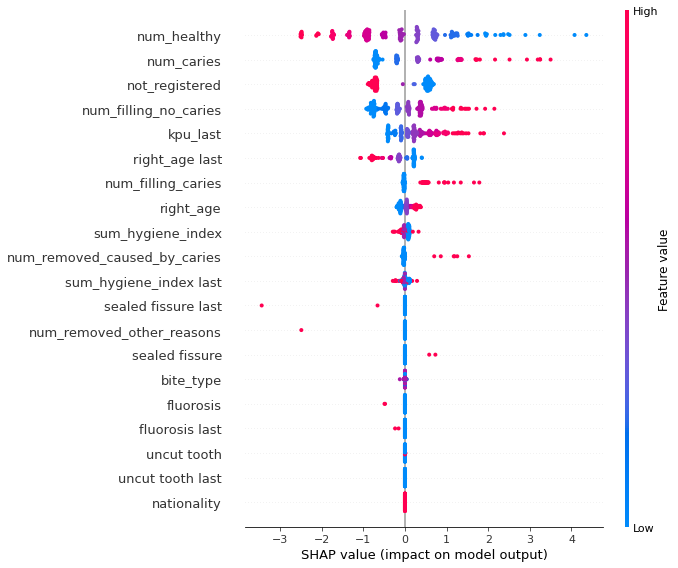

In [36]:
shap.summary_plot(shap_values, x_test)

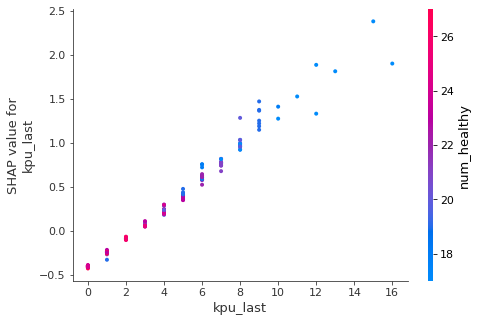

In [37]:
shap.dependence_plot("kpu_last", shap_values, x_test)

In [38]:
test_data = x_test.copy()
test_data[label] = y_test

display(test_data.head())

,prosthesis crown veneer,sealed fissure,uncut tooth,fluorosis,sum_hygiene_index,right_age,nationality,bite_type,prosthesis crown veneer last,sealed fissure last,...,right_age last,not_registered,num_caries,num_filling_caries,num_filling_no_caries,num_healthy,num_removed_caused_by_caries,num_removed_other_reasons,kpu_last,kpu
id,,,,,,,,,,,,,,,,,,,,,
1101.xlsx,0.0,0.0,0.0,0.0,2.0,14.0,1,8,0,0,...,17,0,2,1,4,21,0,0,7,[9]
1102.xlsx,0.0,0.0,1.0,1.0,0.0,15.0,1,8,0,0,...,18,0,2,0,4,22,0,0,6,[6]
1103.xlsx,0.0,0.0,1.0,0.0,1.0,14.0,1,8,0,0,...,17,0,0,0,6,22,0,0,6,[6]
1104.xlsx,0.0,0.0,0.0,0.0,2.0,14.0,1,1,0,0,...,17,0,9,0,0,19,0,0,9,[9]
1105.xlsx,0.0,0.0,0.0,0.0,0.0,14.0,1,8,0,0,...,17,0,1,0,1,26,0,0,2,[3]


In [39]:
x_test

,prosthesis crown veneer,sealed fissure,uncut tooth,fluorosis,sum_hygiene_index,right_age,nationality,bite_type,prosthesis crown veneer last,sealed fissure last,...,sum_hygiene_index last,right_age last,not_registered,num_caries,num_filling_caries,num_filling_no_caries,num_healthy,num_removed_caused_by_caries,num_removed_other_reasons,kpu_last
id,,,,,,,,,,,,,,,,,,,,,
1101.xlsx,0.0,0.0,0.0,0.0,2.0,14.0,1,8,0,0,...,2.0,17,0,2,1,4,21,0,0,7
1102.xlsx,0.0,0.0,1.0,1.0,0.0,15.0,1,8,0,0,...,0.0,18,0,2,0,4,22,0,0,6
1103.xlsx,0.0,0.0,1.0,0.0,1.0,14.0,1,8,0,0,...,1.0,17,0,0,0,6,22,0,0,6
1104.xlsx,0.0,0.0,0.0,0.0,2.0,14.0,1,1,0,0,...,2.0,17,0,9,0,0,19,0,0,9
1105.xlsx,0.0,0.0,0.0,0.0,0.0,14.0,1,8,0,0,...,0.0,17,0,1,0,1,26,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412.xlsx,0.0,0.0,0.0,0.0,2.0,11.0,1,8,0,0,...,2.0,14,0,2,2,2,22,0,0,6
7413.xlsx,0.0,0.0,0.0,0.0,0.0,11.0,1,8,0,0,...,0.0,14,1,0,0,3,24,0,0,3
7414.xlsx,0.0,0.0,0.0,0.0,0.0,11.0,1,5,0,0,...,0.0,14,0,0,0,2,26,0,0,2


In [40]:
test_data = x_test

In [41]:
test_data[label] = y_test

In [42]:
test_data

,prosthesis crown veneer,sealed fissure,uncut tooth,fluorosis,sum_hygiene_index,right_age,nationality,bite_type,prosthesis crown veneer last,sealed fissure last,...,right_age last,not_registered,num_caries,num_filling_caries,num_filling_no_caries,num_healthy,num_removed_caused_by_caries,num_removed_other_reasons,kpu_last,kpu
id,,,,,,,,,,,,,,,,,,,,,
1101.xlsx,0.0,0.0,0.0,0.0,2.0,14.0,1,8,0,0,...,17,0,2,1,4,21,0,0,7,[9]
1102.xlsx,0.0,0.0,1.0,1.0,0.0,15.0,1,8,0,0,...,18,0,2,0,4,22,0,0,6,[6]
1103.xlsx,0.0,0.0,1.0,0.0,1.0,14.0,1,8,0,0,...,17,0,0,0,6,22,0,0,6,[6]
1104.xlsx,0.0,0.0,0.0,0.0,2.0,14.0,1,1,0,0,...,17,0,9,0,0,19,0,0,9,[9]
1105.xlsx,0.0,0.0,0.0,0.0,0.0,14.0,1,8,0,0,...,17,0,1,0,1,26,0,0,2,[3]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412.xlsx,0.0,0.0,0.0,0.0,2.0,11.0,1,8,0,0,...,14,0,2,2,2,22,0,0,6,[6]
7413.xlsx,0.0,0.0,0.0,0.0,0.0,11.0,1,8,0,0,...,14,1,0,0,3,24,0,0,3,[5]
7414.xlsx,0.0,0.0,0.0,0.0,0.0,11.0,1,5,0,0,...,14,0,0,0,2,26,0,0,2,[6]


In [43]:
predictor.feature_importance(test_data)

These features in provided data are not utilized by the predictor and will be ignored: ['prosthesis crown veneer', 'prosthesis crown veneer last', 'uncut tooth last']
Computing feature importance via permutation shuffling for 19 features using 185 rows with 5 shuffle sets...
	7.62s	= Expected runtime (1.52s per shuffle set)
	1.94s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
num_healthy,4.226467e-01,0.089835,0.000231,5,6.076187e-01,2.376748e-01
not_registered,2.592419e-01,0.025554,0.000011,5,3.118577e-01,2.066262e-01
num_filling_no_caries,1.863940e-01,0.055935,0.000867,5,3.015658e-01,7.122209e-02
num_caries,1.734427e-01,0.063455,0.001814,5,3.040981e-01,4.278729e-02
kpu_last,8.545976e-02,0.026184,0.000937,5,1.393723e-01,3.154720e-02
num_filling_caries,5.815789e-02,0.021378,0.001846,5,1.021755e-01,1.414029e-02
right_age,5.604100e-02,0.008179,0.000053,5,7.288097e-02,3.920102e-02
sealed fissure last,4.393942e-02,0.004297,0.000011,5,5.278626e-02,3.509258e-02
num_removed_caused_by_caries,3.990922e-02,0.019961,0.005534,5,8.100839e-02,-1.189965e-03
right_age last,1.890061e-02,0.014936,0.023683,5,4.965455e-02,-1.185334e-02
